In [1]:
import sys
import numpy as np
import os
import json

# Add the directory containing instruments.py to the Python path
custom_module_path = "/home/rebeccaz/Github/vampires_calibration"
sys.path.append(custom_module_path)

import plotting_rewrite as plotting
import instruments_jax as inst

h5_file_path = "/home/rebeccaz/Github/vampires_calibration/mcmc/results/720nm_Adjusted_EM_Gain_1200000_steps.h5"
txt_file_path = "/home/rebeccaz/Github/vampires_calibration/scipy_minimize/data_files/produced/675-50nm_no_IMR_offset_or_IMR_and_HWP_constraints.txt"
txt_save_file_path = "/home/rebeccaz/Github/vampires_calibration/mcmc/results/720nm_Adjusted_EM_Gain.txt"

# Step 1: Defining System Dictionary

In [2]:
filter_wavelength = 720
wavelength_string = filter_wavelength
wavelength_index = 2
nsteps = 1200000
obs_mode = "MBI"

IPOL_em_gains = [1.14, 1.18, 1.18, 1.18]
MBI_em_gains = [1.23, 1.19, 1.2, 1.08]
if obs_mode == "IPOL":
    em_gain = IPOL_em_gains[wavelength_index]
elif obs_mode == "MBI":
    em_gain = MBI_em_gains[wavelength_index]

system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 0, "epsilon": 0, "theta" : 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 0.5 * 2 * np.pi, "theta": 0, "delta_theta": 0},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 0, "epsilon": 0, "theta": 0},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 0.5 * 2 * np.pi, "theta": 0, "delta_theta": 0},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 0.5 * 2 * np.pi, "theta": 0, "delta_theta": 0},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": 0},
        },
    }
}

# Step 2: Loading Chains

dichroic.phi (waves): -0.01039 ± 0.00709
dichroic.epsilon (): 0.29279 ± 0.02342
dichroic.theta (): -44.72991 ± 0.37070
flc.phi (waves): 0.50198 ± 0.01324
flc.delta_theta (): 0.34475 ± 0.44648
optics.phi (waves): 0.02882 ± 0.03011
optics.epsilon (): 0.00521 ± 0.00407
optics.theta (): -0.20951 ± 24.79328
image_rotator.phi (waves): 0.41780 ± 0.00316
hwp.phi (waves): 0.47634 ± 0.00248
hwp.delta_theta (): -0.87189 ± 0.58088
lp.theta (): 0.52136 ± 0.89768
log_f (): -8.12175 ± 1.19308
Chain shape (nsteps, nwalkers, ndim): (1200000, 28, 13)


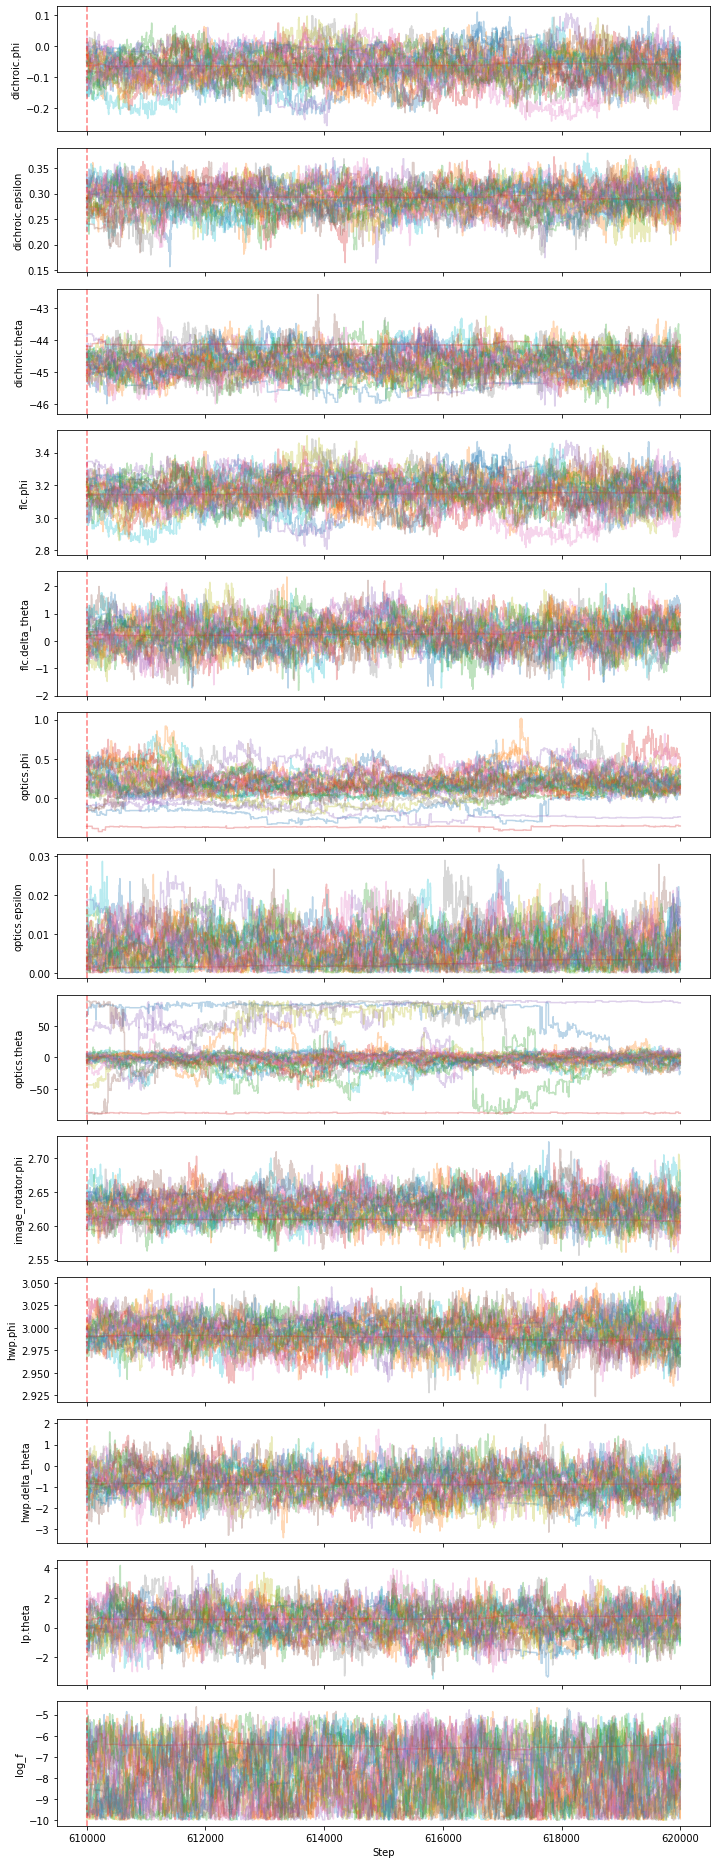

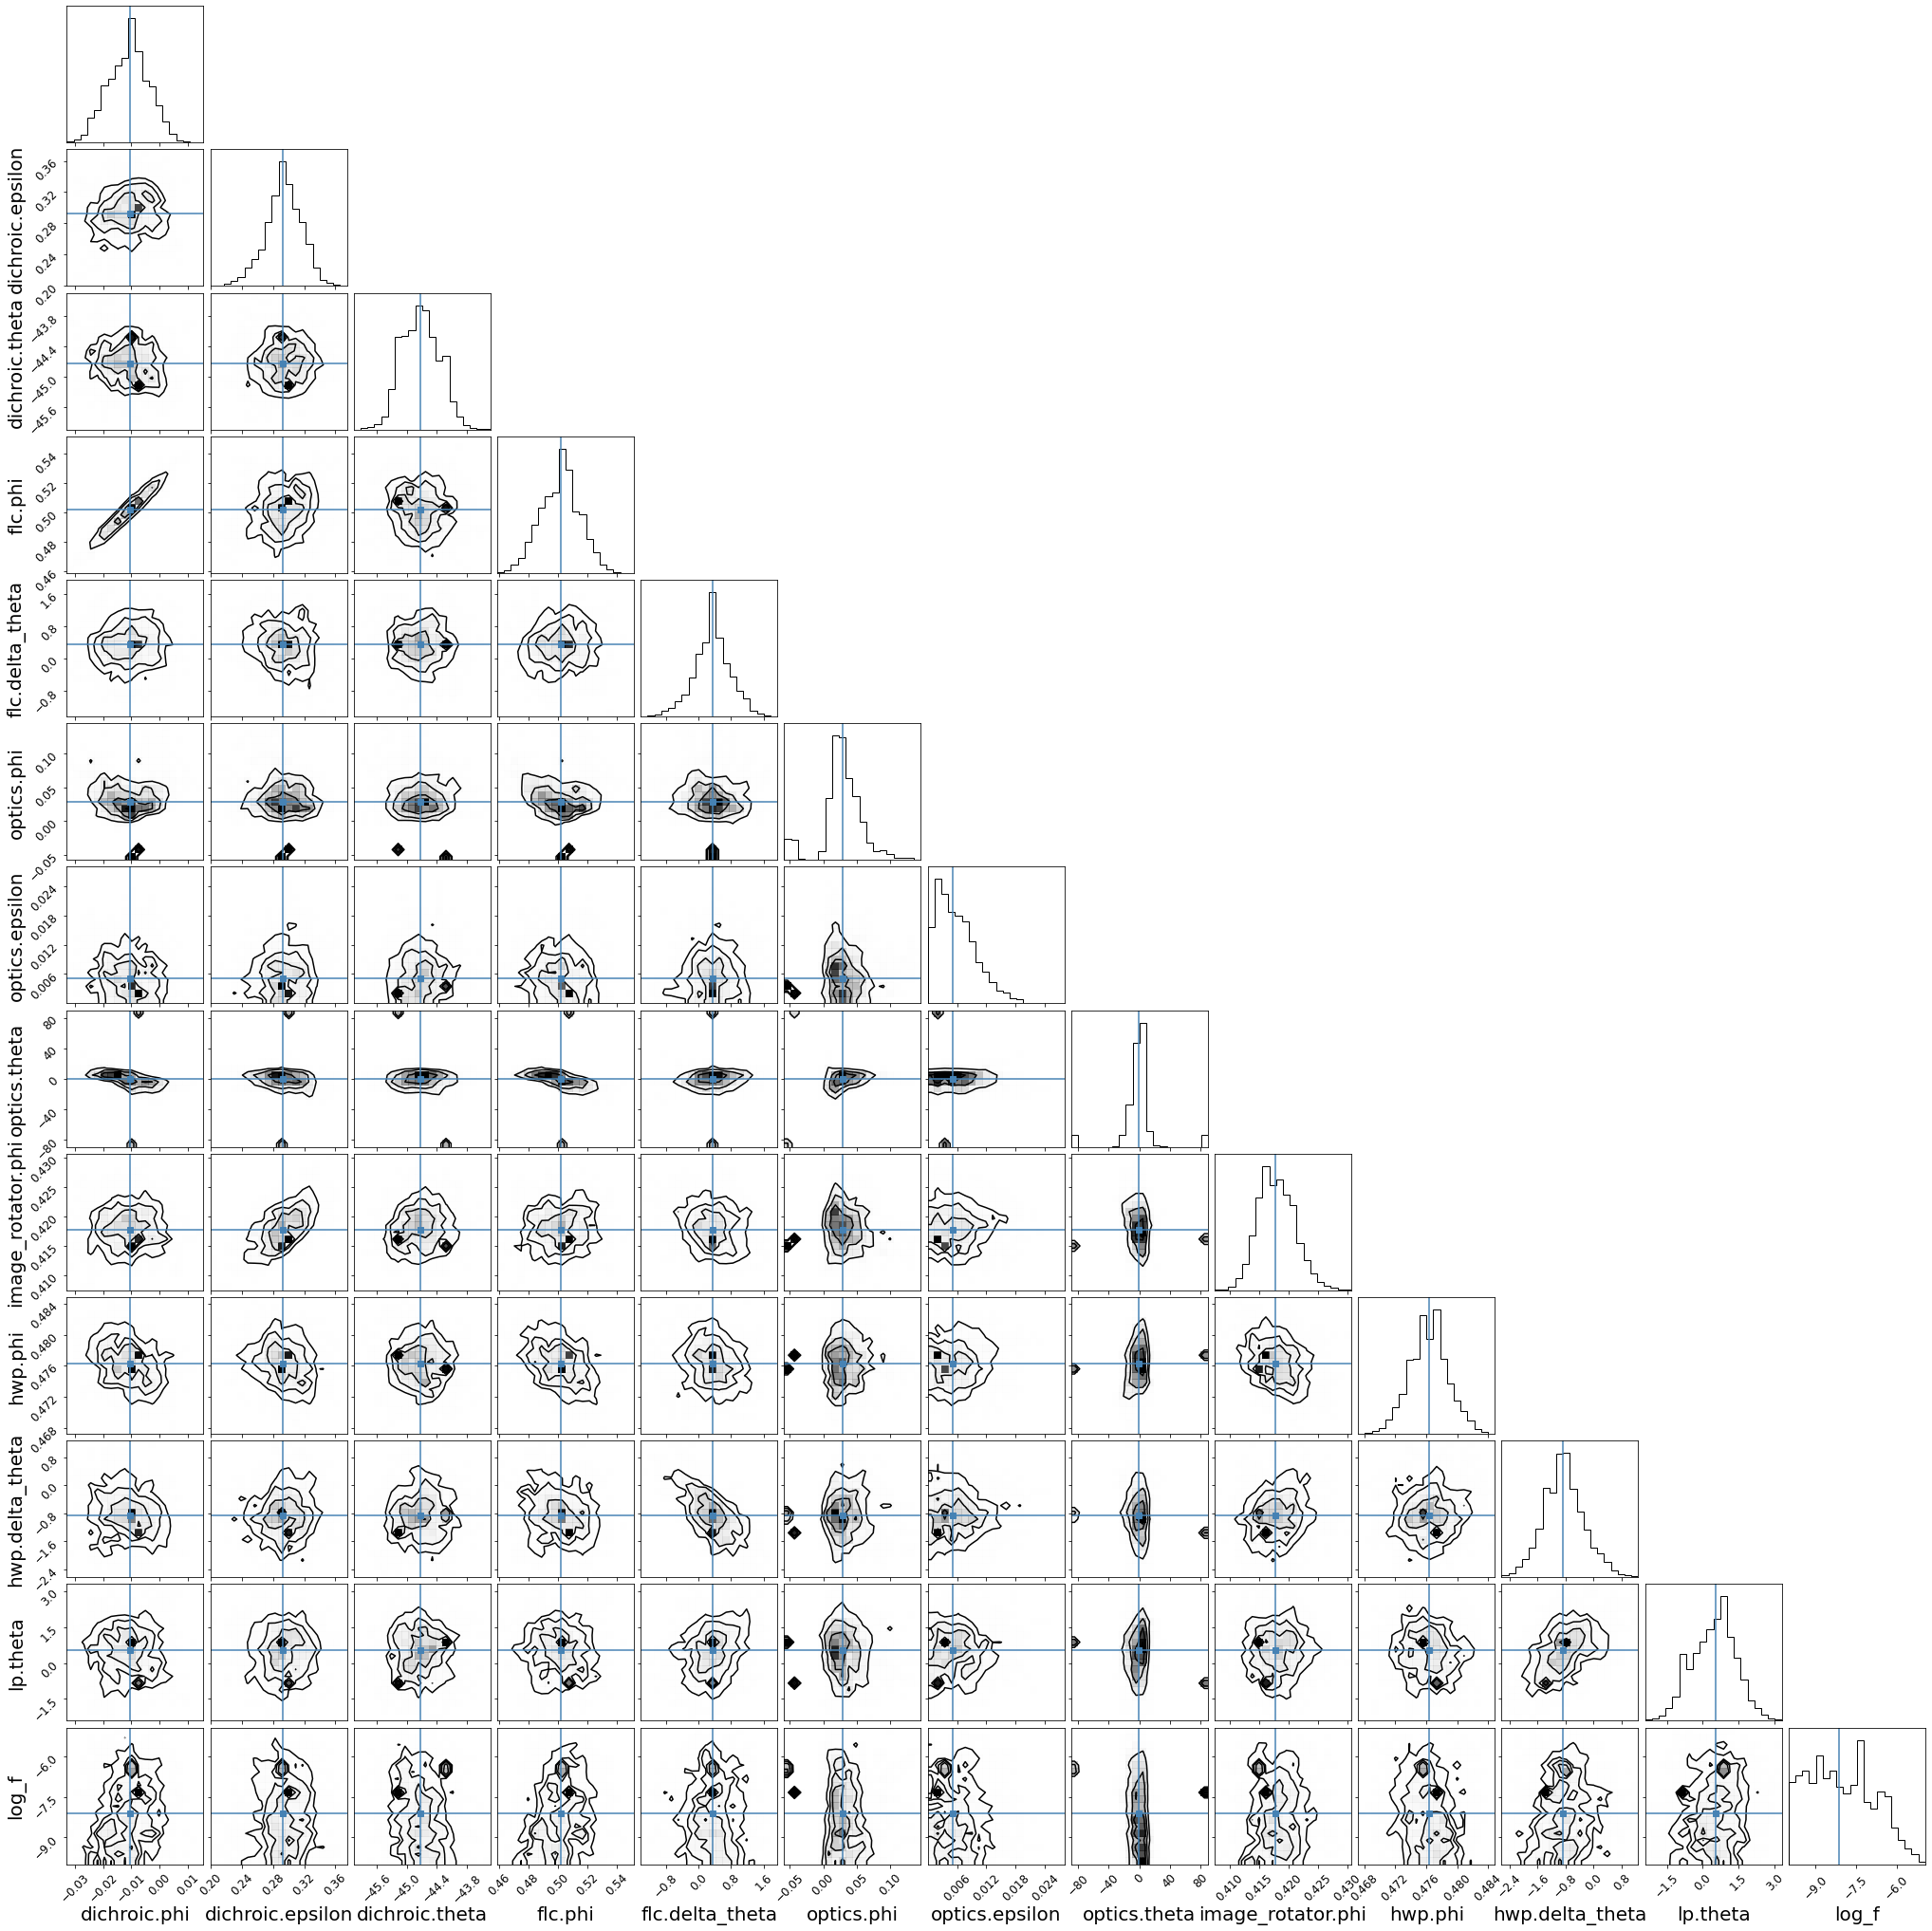

In [3]:
chain, names = plotting.load_chain_and_labels(h5_file_path, txt_file_path, include_logf = True)
chain_step_range = (610000, 620000)
corner_plot_step_range = (619000, 620000)

# Print median ± std for each parameter
plotting.summarize_posteriors(chain, names, system_dict, step_range=corner_plot_step_range, 
    txt_save_file_path = txt_save_file_path, txt_file_path = txt_file_path)

# Check chain shape after loading
print("Chain shape (nsteps, nwalkers, ndim):", chain.shape)

# Plot trace plots for MCMC chains
plotting.plot_trace(chain, names, step_range=chain_step_range, max_walkers=100)

# Plot corner plot from flattened chain
plotting.plot_corner_flat(chain, names, step_range=corner_plot_step_range)


# Step 3: Plot median configuration of posteriors

In [4]:
file_path = "/home/rebeccaz/Github/vampires_calibration/data/20230914_processed_table.csv"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)

In [5]:
# Loading in median parameters
with open(txt_save_file_path, "r") as f:
    past_fit = json.load(f)

# print(past_fit)

theta_pol = past_fit["lp"]["theta"]
delta_HWP = past_fit["hwp"]["phi"] 
offset_HWP = past_fit["hwp"]["delta_theta"]
delta_derot = past_fit["image_rotator"]["phi"] 
delta_opts = past_fit["optics"]["phi"]
epsilon_opts = past_fit["optics"]["epsilon"]
rot_opts = past_fit["optics"]["theta"]
delta_FLC = past_fit["flc"]["phi"] 
rot_FLC = past_fit["flc"]["delta_theta"]
delta_dichroic = past_fit["dichroic"]["phi"]
epsilon_dichroic = past_fit["dichroic"]["epsilon"]
rot_dichroic = past_fit["dichroic"]["theta"]

print(delta_HWP)

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary

system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {
                "phi": delta_dichroic * 2 * np.pi,
                "epsilon": epsilon_dichroic,
                "theta": rot_dichroic,
            },
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {
                "phi": delta_FLC * 2 * np.pi,
                "theta": 0,  # not fitted
                "delta_theta": rot_FLC,
            },
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {
                "phi": delta_opts * 2 * np.pi,
                "epsilon": epsilon_opts,
                "theta": rot_opts,
            },
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {
                "phi": delta_derot * 2 * np.pi,
                "theta": 0,  # not fitted
                "delta_theta": 0,  # not fitted
            },
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {
                "phi": delta_HWP * 2 * np.pi,
                "theta": 0,  # not fitted
                "delta_theta": offset_HWP,
            },
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
    }
}

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())


0.5041490802687768
[[0.42287271 0.42285789 0.00354024 0.        ]
 [0.42287271 0.42285789 0.00354024 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


logl value: 22.247645818500573


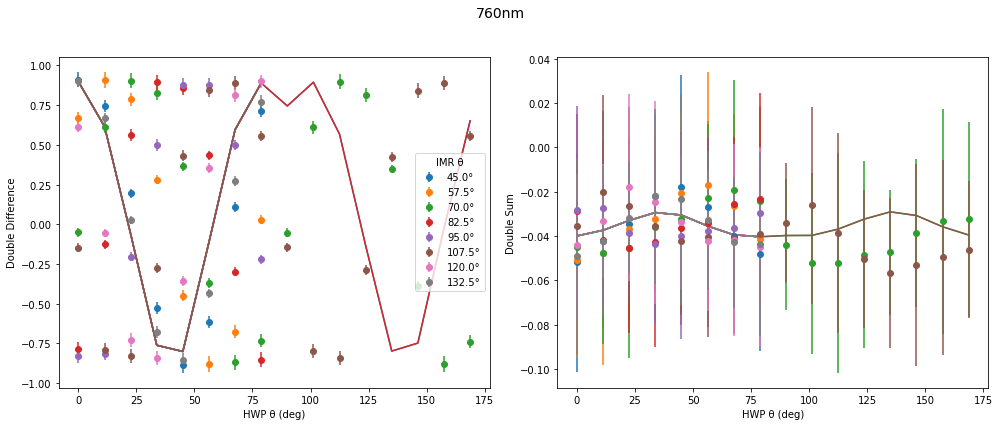

In [6]:
# Fittin for all parameters

p0 = {
    "wollaston": {"transmission_ratio": em_gain}, 
}

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
# updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 4: Plotting Random Chains for Fitting (UNDER CONSTRUCTION)

In [7]:
# import sys
# import os

# # Add the directory containing instruments.py to the Python path
# custom_module_path = "/home/rebeccaz/Github/vampires_calibration"
# sys.path.append(custom_module_path)

# import plotting_rewrite as plotting
# import numpy as np

# all_step_range = (0, None)
# corner_plot_step_range = (24000, 25000)

# # Define the system configuration dictionary
# system_dict = {
#     "components": {
#         "wollaston": {
#             "type": "wollaston_prism_function",
#             "properties": {"beam": "o", "transmission_ratio": 1.18},
#         },
#         "dichroic": {
#             "type": "diattenuator_retarder_function",
#             "properties": {"phi": 0, "epsilon": 0, "theta": 0},
#         },
#         "flc": {
#             "type": "general_retarder_function",
#             "properties": {"phi": 0.5 * 2 * np.pi, "theta": 0, "delta_theta": 0},
#         },
#         "optics": {
#             "type": "diattenuator_retarder_function",
#             "properties": {"phi": 0, "epsilon": 0, "theta": 0},
#         },
#         "image_rotator": {
#             "type": "general_retarder_function",
#             "properties": {"phi": 0.5 * 2 * np.pi, "theta": 0, "delta_theta": 0},
#         },
#         "hwp": {
#             "type": "general_retarder_function",
#             "properties": {"phi": 0.5, "theta": 0, "delta_theta": 0},
#         },
#         "lp": {
#             "type": "general_linear_polarizer_function_with_theta",
#             "properties": {"theta": 0},
#         },
#     }
# }

# # Input paths and call plotting function
# h5_filename = "675nm_no_IMR_offset_with_dichroic.h5"
# txt_filename = "675-50nm.txt"
# csv_file_path = "/home/rebeccaz/Github/vampires_calibration/data/20230914_processed_table.csv"

# plotting.plot_mcmc_fits_double_diff_sum(
#     h5_filename=h5_filename,
#     txt_filename=txt_filename,
#     csv_path=csv_file_path,
#     filter_wavelength="675-50",
#     system_dict=system_dict,
#     wavelength_str="675nm",
#     n_samples=50,
#     step_range = all_step_range
# )
